In [15]:
import os
import sys
sys.path.append("..")  # add top folder to path

import impepdom
import numpy as np
import pandas as pd
import scipy as sp
import torch

In [16]:
# Import csv and extract the best hyperparameters

path = '../store/hyperparams'

hyperparams = []


for file in os.listdir(path):

    allele = 'HLA-' + file[10:-4].upper() # change to appropriate name
    df = pd.read_csv(path + '/' + file)
    idx = (df['min_auc'].notna() & df['mean_ppv'].notna())
    
    # best_3_rows = (-sp.stats.hmean([df['min_auc'][idx], df['mean_ppv'][idx]])).argsort()[:3] # for top 3 rows with best harmonic mean value
    best_row = sp.stats.hmean([df['min_auc'][idx], df['mean_ppv'][idx]]).argmax() # for top 1 row with best harmonic mean value

    
    hyperparams.append({
        'hla_allele': allele, 
        'padding': df['padding'][best_row],
        #'batch_size': int(df['batch_size'][best_row]),
        'batch_size': int(df['batch_size'][best_row]), 
        #'num_epochs': int(df['num_epochs'][best_row]),
        'num_epochs': int(np.mean(df['num_epochs'][best_3_rows])),
        #'learning_rate': float(df['learning_rate'][best_row])
        'learning_rate': float(np.mean(df['learning_rate'][best_3_rows]))
    })

KeyError: 'min_auc'

In [ ]:
# Train models with these hyperparameters

results = []

impepdom.time_tracker.reset_timer() 

for hyp in hyperparams:
    
    model = impepdom.models.MultilayerPerceptron(num_hidden_layers=2, hidden_layer_size=100)

    dataset = impepdom.PeptideDataset(
        hla_allele=hyp['hla_allele'],
        padding='flurry',
        toy=False)

    save_folder, baseline_metrics, _ = impepdom.run_experiment(
        model=model,
        dataset=dataset,
        train_fold_idx=[0, 1, 2, 3],
        learning_rate=hyp['learning_rate'],
        num_epochs=hyp['num_epochs'],
        batch_size=hyp['batch_size'])
    
    trained_model, train_history = impepdom.load_trained_model(model, save_folder)
    
    
    X_test, y_test = dataset.get_fold(fold_idx=[4])
    y_proba = model(torch.tensor(X_test, dtype=torch.float)).detach().numpy()
    
    results.append({
        'hla_allele': hyp['hla_allele'],
        'y_test': y_test,
        'y_proba': y_proba
        })

[0 m 19 s] peptide dataset initialized
epoch 1/5 started at 0.0092 s
train loss: 0.1387 accuracy: 0.9524 auc: 0.9451

epoch 2/5 started at 20.1586 s
train loss: 0.1367 accuracy: 0.9530 auc: 0.9507

epoch 3/5 started at 40.6022 s
train loss: 0.1375 accuracy: 0.9552 auc: 0.9555

epoch 4/5 started at 57.1608 s


In [19]:
# Report metrics

allele_store = []
n_store = []
n_bind_store = []
ppv_store = []
auc_store = []
auc_01_store = []
ppv_100_store = []

for result in results:
    
    y_true = result['y_test']
    y_proba = result['y_proba']
    
    allele_store.append(result['hla_allele'])
    n_store.append(len(y_true))
    n_bind_store.append(sum(y_true == 1))
    ppv_store.append(impepdom.metrics.ppv(y_true, y_proba))
    auc_store.append(impepdom.metrics.auc(y_true, y_proba))
    auc_01_store.append(impepdom.metrics.auc_01(y_true, y_proba))
    ppv_100_store.append(impepdom.metrics.ppv_100(y_true, y_proba))
    
metrics_report = pd.DataFrame({
    'Allele': allele_store,
    'N': n_store,
    'Nbind': n_bind_store,
    'PPV': ppv_store,
    'AUC': auc_store,
    'AUC01': auc_01_store,
    'PPV100': ppv_100_store
    })

In [20]:
metrics_report

,Allele,N,Nbind,PPV,AUC,AUC01,PPV100
0,HLA-B27:05,29995,1775,0.800000,0.964309,0.883939,0.92
1,HLA-A02:01,187844,3372,0.804567,0.901746,0.751620,1.00
2,HLA-B44:03,24073,1488,0.865591,0.968556,0.919545,0.98
3,HLA-A24:02,55304,1297,0.686970,0.961744,0.886917,0.89
4,HLA-B07:02,59311,2576,0.779503,0.972424,0.917895,1.00
5,HLA-B15:01,23235,1159,0.861087,0.965831,0.904295,0.91
6,HLA-A03:01,100012,2921,0.719274,0.927025,0.815874,1.00
7,HLA-A01:01,209698,2150,0.620465,0.915609,0.846112,1.00
8,HLA-A68:01,39201,2081,0.745795,0.972653,0.923003,0.98
9,HLA-B08:01,49804,997,0.716148,0.951253,0.904331,1.00


In [28]:
os.makedirs('../store/reports', exist_ok=True)
metrics_report.to_csv('../store/reports/mlp_2x10_flurry_report_v2.csv')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [5]:
num = [0,1,2,3,4]

path = '../datasets/MHC_I_el_allele_specific/HLA-A01:01/'
files = [path+'c00%d' % i for i in num]

files

['../datasets/MHC_I_el_allele_specific/HLA-A01:01/c000',
 '../datasets/MHC_I_el_allele_specific/HLA-A01:01/c001',
 '../datasets/MHC_I_el_allele_specific/HLA-A01:01/c002',
 '../datasets/MHC_I_el_allele_specific/HLA-A01:01/c003',
 '../datasets/MHC_I_el_allele_specific/HLA-A01:01/c004']

In [6]:
data = [np.loadtxt(f, dtype = 'str') for f in files]
data = np.vstack(data)

In [9]:
data

array([['AAAAAAAFPSLP', '0.000000'],
       ['AAAAAAAGAAGKET', '0.000000'],
       ['AAAAAAAGAAVLP', '0.000000'],
       ...,
       ['YYYYNGYNNYNYN', '0.000000'],
       ['cLDTAQRNLY', '1.000000'],
       ['mQQKLVDQNIFSFY', '1.000000']], dtype='<U14')

In [9]:
x = data[:,0]

In [15]:
y = data[:,1].astype('float32')

In [16]:
y

array([0., 0., 0., ..., 0., 1., 1.], dtype=float32)

In [81]:
pep_len = []
for i in range(len(x)):
    length = len(x[i])
    pep_len.append(length)

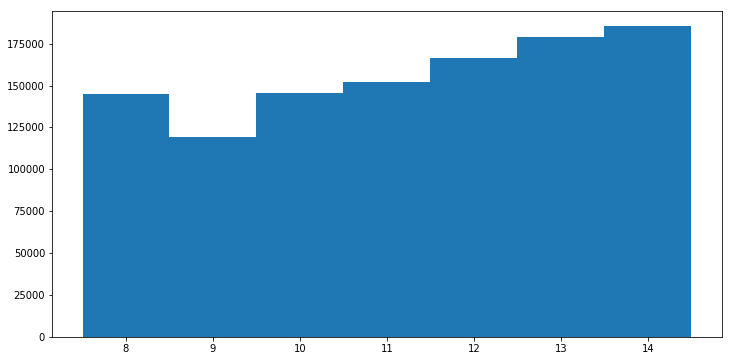

In [82]:
plt.figure(figsize=(12,6))
plt.hist(pep_len, bins = np.arange(min(pep_len)-0.5, max(pep_len)+1.5 , 1.0))
plt.show()

In [83]:
positive_num = 0
for i in range(len(y)):
    if y[i] == 1:
        positive_num +=1 

In [86]:
positive_num

10473

In [3]:
from torchvision.datasets import MNIST

In [7]:
mnist = MNIST(root='~/Desktop/MNIST', download=True)

100.1%

Extracting /Users/Munchic/Desktop/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /Users/Munchic/Desktop/MNIST/MNIST/raw


113.5%

Extracting /Users/Munchic/Desktop/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/Munchic/Desktop/MNIST/MNIST/raw


100.4%

Extracting /Users/Munchic/Desktop/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/Munchic/Desktop/MNIST/MNIST/raw


180.4%

Extracting /Users/Munchic/Desktop/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/Munchic/Desktop/MNIST/MNIST/raw
Processing...
Done!


In [11]:
mnist.labels

AttributeError: 'MNIST' object has no attribute 'labels'

can be P3, not only P2
MHCflurry
9mer 4 5 or 5 4
Blossom matrix encoding
Plot validation training
Extract subset of 9mers (if things don't work)
(!) NNAlign -> take set of peptides, train model, the model will run on simple feedforward network (baseline)
AUC curve shape matters (AUC 0.1)
PPV (positive predicted value) - take top 10 peptides for each allele, how many are positive?
Cross validation, combine all predictions and targets and get total AUC (scaling issue)
9-4

In [1]:
def init_train_hist():
    metrics = ['loss', 'acc', 'auc', 'auc0.1', 'pcc']
    train_history = {
        'train': {},
        'val': {}
    }

    for metric in metrics:
        train_history['train'][metric] = []
        train_history['val'][metric] = []

    return train_history

In [2]:
init_train_hist()

{'train': {'loss': [], 'acc': [], 'auc': [], 'auc0.1': [], 'pcc': []},
 'val': {'loss': [], 'acc': [], 'auc': [], 'auc0.1': [], 'pcc': []}}

In [3]:
ev = '343'

In [5]:
{
    'hu' + ev: 23
}

{'hu343': 23}

In [6]:
a = [{'a': 1, 'b': 2}, {'a': 2, 'b': 1}]

In [7]:
a.sort(key=(lambda x: x['b']))

In [8]:
a

[{'a': 2, 'b': 1}, {'a': 1, 'b': 2}]

In [12]:
b = [1, 2, 4, 5]
b[b != 5]

2

In [20]:
b = [1, 2, 4, 5]
c = copy.copy(b)

In [24]:
remove(b, 2)


NameError: name 'remove' is not defined

In [22]:
c

[1, 4, 5]

In [23]:
b

[1, 2, 4, 5]

In [13]:
from collections import Counter

a = [1,2,3,1,2,1,1,1,3,2,2, 2, 2, 2, 2, 2, 1]
b = Counter(a)
print(b.most_common(1)[0][0])

2


In [1]:
import os
import sys
sys.path.append("..")  # add top folder to path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import roc_auc_score
import torch
import impepdom

model = impepdom.models.MultilayerPerceptron(num_hidden_layers=2, hidden_layer_size=100)
dataset = impepdom.PeptideDataset(
    hla_allele='HLA-A01:01',
    padding='flurry',
    toy=True)

folder, baseline_metrics, _ = impepdom.run_experiment(
    model,
    dataset,
    train_fold_idx=[1, 2, 3],
    val_fold_idx=[0],
    learning_rate=2e-3,
    num_epochs=5,
    batch_size=32)

trained_model, train_history = impepdom.load_trained_model(model, folder)

[0 m 6 s] peptide dataset initialized
epoch 1/5 started at 0.0005 s
train loss: 0.2155 acc: 0.9902 auc: 0.5554
val loss: 0.0719 acc: 0.9902 auc: 0.4738

epoch 2/5 started at 0.3651 s
train loss: 0.0712 acc: 0.9896 auc: 0.5553
val loss: 0.0348 acc: 0.9951 auc: 0.3623

epoch 3/5 started at 0.7529 s
train loss: 0.0473 acc: 0.9922 auc: 0.7050
val loss: 0.0550 acc: 0.9922 auc: 0.4670

epoch 4/5 started at 1.1396 s
train loss: 0.0510 acc: 0.9909 auc: 0.7390
val loss: 0.0735 acc: 0.9902 auc: 0.4110

epoch 5/5 started at 1.5242 s
train loss: 0.0376 acc: 0.9932 auc: 0.7814
val loss: 0.0481 acc: 0.9941 auc: 0.3112

training completed in 0 m 1.9073 s
best validation auc: 0.4738


In [3]:
import os
import sys
sys.path.append("..")  # add top folder to path

import impepdom

# os.listdir('../datasets/MHC_I_el_allele_specific')
hla_alleles = [
    'HLA-B44:03',  
    'HLA-B08:01',  # >>> Khoi 1
    'HLA-A01:01',
    'HLA-B15:01',  
    'HLA-A02:01', 
    'HLA-A03:01',  # <<< Khoi 1
    'HLA-B07:02',  # >>> Khoi 2 <<<
    'HLA-A24:02',  
    'HLA-B27:05',  # >>> Michael
    'HLA-A68:01'   # <<< Michael
]

hla_alleles_khoi_1 = hla_alleles[1:6]
hla_alleles_khoi_2 = hla_alleles[6:7]
hla_alleles_michael = hla_alleles[8:]
hla_alleles_test = ['HLA-A01:01']
hla_alleles_rerun = ['HLA-B44:03', 'HLA-A24:02']

impepdom.time_tracker.reset_timer()  # start counting time

for i, hla_allele in enumerate(hla_alleles_test):  # change allele list here
    print(impepdom.time_tracker.now() + 'working with allele {0} out of {1}'.format(i + 1, len(hla_alleles_test)))  # change allele list here
    
    model = impepdom.models.MultilayerPerceptron(num_hidden_layers=2, hidden_layer_size=100)  # reset model
    dataset = impepdom.PeptideDataset(
        hla_allele=hla_allele,  
        padding='flurry',
        toy=True)
        
    best_config = impepdom.hyperparam_grid_search(
        model,
        dataset,
        max_epochs=15,
        batch_sizes=[32, 64],
        learning_rates=[5e-4, 1e-3],
    )

[0 m 0 s] working with allele 1 out of 1
[0 m 7 s] peptide dataset initialized
[0 m 7 s] running experiment 1 out of 18
[0 m 31 s] experiment 1 results saved
[0 m 31 s] running experiment 2 out of 18


KeyboardInterrupt: 